## Gemini multimodality getting-sarted

Gemini is the most advanced and versatile model developed by Google to-date. It results from a large-scale collaborative effort by teams across Google, including Google DeepMind and Google Research. In this notebook, we will explore Gemini's capabilities for analyzing and working with multimodal data.



In [1]:
!pip install --upgrade google-cloud-aiplatform -q

In [2]:
import IPython
import time
import typing
import sys
from matplotlib.pylab import plt
from PIL.Image import Image as PILImageType
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from PIL import ImageOps as PILImageOps
import requests
from io import BytesIO
import json
import markdown
from pathlib import Path
from urllib.parse import urlparse
import vertexai
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

In [3]:
def restart_kernel() -> typing.NoReturn:
    """
    restart colab kernel
    """
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

def is_colab_env() -> bool:
    """
    return true if Colab is the execution env, otherwise false
    """
    return "google.colab" in sys.modules

def auth_with_gcp() -> typing.NoReturn:
    """
    Authenticate with GCP
    """
    if is_colab_env():
         # Authenticate user to Google Cloud
        from google.colab import auth
        auth.authenticate_user()

def is_valid_uri(uri: str) -> bool:
    """
    Check if a URI is valid.
    :param uri: URI
    :return: True if the URI is valid, False otherwise
    """
    try:
        result = urlparse(uri)
        # Check if the scheme and netloc are present
        return all([result.scheme, result.netloc])
    except:
        return False


def solve_image_url(url: str) -> str:
    """
    converts gcs uri to url for image display.
    """
    url_parts = urlparse(url)
    scheme = url_parts.scheme
    if scheme == "gs":
        return "https://storage.googleapis.com/" + url.replace("gs://", "").replace(
            " ", "%20"
        )
    elif scheme in ["http", "https"]:
        return url
    raise Exception("Invalid scheme")

def get_image_from_url(url: str) -> PILImageType:
    """
    Create an image from url and return it
    """
    http_uri =solve_image_url(url)
    response = requests.get(http_uri)
    image_bytes = BytesIO(response.content)
    image_obj = PILImage.open(image_bytes)
    return image_obj

def get_image_from_path(path: str) -> PILImageType:
    """
    Read image from file and return it
    """
    return PILImage.open(path)


def get_image_from_anywhere(uri_or_path: str) -> PILImageType:
    """
    read an image from an url or local file and return it
    """
    uri_or_path = str(uri_or_path)
    if is_valid_uri(uri_or_path):
        return get_image_from_url(uri_or_path)
    else:
        return get_image_from_path(uri_or_path)


def get_image_from_part(prompt_part: Part) -> PILImageType:
    """
    convert a. multimodal prompt part to and image
    """
    is_an_image = isinstance(prompt_part, Image)
    is_a_part = isinstance(prompt_part, Part)

    assert any([is_an_image, is_a_part]), "Invalid prompt part"
    if is_an_image:
        img = prompt_part._pil_image
    elif is_a_part:
        part_uri = prompt_part.file_data.file_uri
        img = get_image_from_url(part_uri)
    return img


def display_content_as_image(
        content: str | Image | Part,
        max_width: int = 600,
        max_height: int = 350) -> bool:
    """
    Display multimodal prompt part as image
    """
    if not isinstance(content, (Image, Part)):
        return False
    try:
        pil_image = get_image_from_part(content)
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PILImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)
    except:
        return False
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    """
    Display multimodal prompt part as video
    """
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

def markdown2json(markdown_str : str):
    """
    transform a markdown json str into a json object
    """
    start = "```json"
    end = "```"
    markdown_str=markdown_str.replace(start,"*")
    markdown_str=markdown_str.replace(end,"*")
    re=markdown_str.split("*")
    res=re[1]
    json_obj = json.loads(res)
    return json_obj


In [4]:
#restart_kernel()

In [4]:
auth_with_gcp()

In [5]:
!gcloud projects list | grep "build-with-ai"

build-with-ai-project       Build-With-AI-Project       430300616222


# Getting-Started with Gemini API

In [6]:
# Define project information
PROJECT_ID = "build-with-ai-project"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [7]:
model = GenerativeModel("gemini-1.0-pro")
responses = model.generate_content("Why is the sky blue?", stream=True)
for response in responses:
    print(response.text, end="")

The sky appears blue because of a phenomenon called Rayleigh scattering. Sunlight is made up of all colors of the visible spectrum, but when sunlight passes through the Earth's atmosphere, the shorter wavelength colors (blue and violet) are scattered more by molecules in the air than the longer wavelength colors (red and orange). This is because the shorter wavelength colors have a higher frequency and are therefore more likely to interact with the molecules in the air.

The amount of scattering depends on the wavelength of the light and the size of the particles in the air. The particles in the air are much smaller than the wavelength of visible light, so the scattering is mainly elastic, meaning that the wavelength of the light does not change.

The scattered light is then redirected in all directions, which is why we see the sky as blue from all angles. The amount of scattering also depends on the time of day and the location of the observer. The sky is typically bluest during the d

In [8]:
prompt = """Create a numbered list of 10 items. Each item in the list should be a trend in the tech industry.
Each trend should be less than 5 words."""  # try your own prompt
responses = model.generate_content(prompt, stream=True)
for response in responses:
    print(response.text, end="")

1. Artificial intelligence
2. Blockchain technology
3. Cloud computing
4. Data analytics
5. Edge computing
6. Internet of Things (IoT)
7. Machine learning
8. Robotic process automation (RPA)
9. Virtual reality/augmented reality (VR/AR)
10. 5G

In [9]:
chat = model.start_chat()
prompt = """My name is Ned. You are my personal assistant. My favorite movies are Lord of the Rings and Hobbit.
Suggest another movie I might like.
"""
responses = chat.send_message(prompt, stream=True)
for response in responses:
    print(response.text, end="")

Based on your preference for "Lord of the Rings" and "Hobbit," which are fantasy adventure films with epic storylines, strong characters, and stunning visuals, here are a few movie suggestions that you might enjoy:

* **Game of Thrones** (TV series): A sprawling fantasy epic with a complex cast of characters, political intrigue, and spectacular battles.
* **The Princess Bride** (1987): A whimsical and charming fairy tale adventure with a timeless appeal.
* **Stardust** (2007): A magical adventure set in a Victorian-era fantasy world with a star-crossed love story and thrilling action sequences.
* **The Chronicles of Narnia** film series: Based on the classic fantasy novels by C.S. Lewis, these films offer a captivating world of talking animals, mythical creatures, and epic battles.
* **Harry Potter** film series: A beloved fantasy franchise that follows the adventures of a young wizard as he learns about his magical powers and faces challenges.

In [10]:
prompt = "Are my favorite movies based on a book series?"
responses = chat.send_message(prompt, stream=True)
for response in responses:
    print(response.text, end="")

Yes, both of your favorite movies, "Lord of the Rings" and "Hobbit," are based on book series by J.R.R. Tolkien.

* **The Lord of the Rings** is a trilogy of epic fantasy novels published between 1954 and 1955. It tells the story of the hobbit Frodo Baggins, who must travel to Mount Doom in the land of Mordor to destroy the One Ring, an evil artifact created by the Dark Lord Sauron.
* **The Hobbit** is a prequel to "The Lord of the Rings" and was published in 1937. It follows the adventures of Bilbo Baggins, Frodo's uncle, as he travels with a group of dwarves to reclaim the Lonely Mountain from the dragon Smaug.

Both book series have been critically acclaimed and have sold millions of copies worldwide. They are considered to be among the greatest works of fantasy literature ever written.

In addition to the book series, there have been several film adaptations of "The Lord of the Rings" and "The Hobbit." The Lord of the Rings film trilogy, directed by Peter Jackson, was released betw

In [11]:
chat.history


[role: "user"
 parts {
   text: "My name is Ned. You are my personal assistant. My favorite movies are Lord of the Rings and Hobbit.\nSuggest another movie I might like.\n"
 },
 role: "model"
 parts {
   text: "Based on your preference for \"Lord of the Rings\" and \"Hobbit,\" which are fantasy adventure films with epic storylines, strong characters, and stunning visuals, here are a few movie suggestions that you might enjoy:\n\n* **Game of Thrones** (TV series): A sprawling fantasy epic with a complex cast of characters, political intrigue, and spectacular battles.\n* **The Princess Bride** (1987): A whimsical and charming fairy tale adventure with a timeless appeal.\n* **Stardust** (2007): A magical adventure set in a Victorian-era fantasy world with a star-crossed love story and thrilling action sequences.\n* **The Chronicles of Narnia** film series: Based on the classic fantasy novels by C.S. Lewis, these films offer a captivating world of talking animals, mythical creatures, and e

# Exploring Multimodal Capabilities


# Image understanding

Copying gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg...
/ [1 files][ 17.4 KiB/ 17.4 KiB]                                                
Operation completed over 1 objects/17.4 KiB.                                     


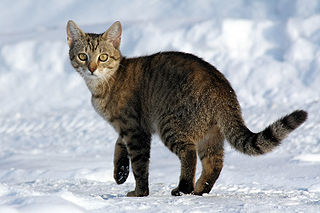

Describe this image?
 The image shows a gray cat with black stripes walking in the snow. The cat has a white belly and white paws. The cat's eyes are yellow and its nose is pink. The cat's tail is long and striped. The cat is walking towards the camera. The background is a blur of snow.

In [12]:
# initialize the model
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

# Download an image from Google Cloud Storage
! gsutil cp "gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg" ./image.jpg

# Prepare model request
image = Image.load_from_file("image.jpg")
prompt = "Describe this image?"

multimodal_prompt = [image, prompt]
print_multimodal_prompt(multimodal_prompt)

gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
for result in gemini_responses:
    print(result.text, end="")

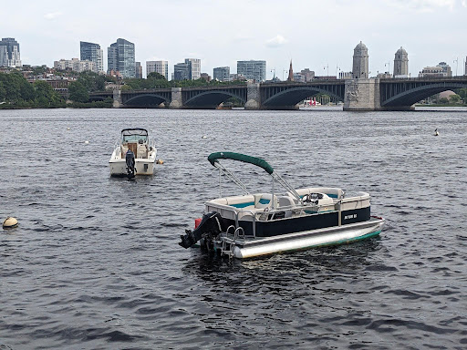

Describe the scene?
 Two pontoon boats are anchored in the Charles River in Boston, Massachusetts. In the background are two bridges and the Boston skyline.

In [13]:
# Load image from Cloud Storage URI
gcs_uri = "gs://cloud-samples-data/generative-ai/image/boats.jpeg"

# Prepare contents
image = Part.from_uri(gcs_uri, mime_type="image/jpeg")
prompt = "Describe the scene?"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
for result in gemini_responses:
    print(result.text, end="")


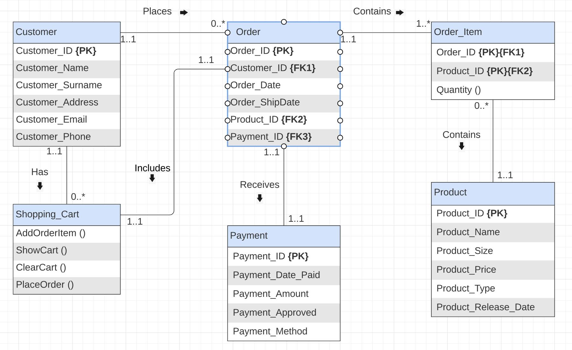

Describe the ERD diagram
Generates the sql code to create the schema in the image


In [17]:
# Download image from URL and save it locally
image_url = "https://i.stack.imgur.com/676e8.png"
image_pil = get_image_from_url(image_url)
# Entity Relationship Diagram (ERD)?
image_path = "diagram.jpeg"
image_pil = image_pil.convert("RGB")
image_pil.save(image_path)

# Prepare contents
image = Image.load_from_file(image_path)
description_prompt = "Describe the ERD diagram"
sql_prompt = "Generates the sql code to create the schema in the image"
multimodal_prompt = [image, description_prompt, sql_prompt]
print_multimodal_prompt(multimodal_prompt)


In [15]:
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
# max_output_tokens -> supported range [1, 2049)
try:
    for result in gemini_responses:
        print(result.text, end="") # it should throw an error
except Exception as e:
    print(e)

 The image shows a relational database design. There are six tables: Customer, Order, Shopping_Cart, Payment, Product and Order_Item. The Customer table stores information about customers, such as their ID, name, address, email, and phone number. The Order table stores information about orders, such as the order ID, customer ID, order date, shipping date, product ID, and payment ID. The Shopping_Cart table stores information about shopping carts, such as the customer ID and the products in the cart. The Payment table stores information about payments, such as the payment ID, payment date, payment amount, and payment method. The Product table stores information about products, such as the product ID, product name, product size, product price, product type, and product release date. The Order_Item table stores information about order items, such as the order ID, product ID, and quantity.

The database also has the following constraints:
- The Customer table has a primary key on the Custo

**Split the prompt could help**

In [19]:
multimodal_prompt = [image, description_prompt]
gemini_response = multimodal_model.generate_content(multimodal_prompt)
print(gemini_response.text)

 The ERD diagram consists of the following tables:

- Customer: This table stores information about customers, such as their ID, name, surname, address, email, and phone number.
- Order: This table stores information about orders, such as the order ID, customer ID, order date, order ship date, product ID, and payment ID.
- Payment: This table stores information about payments, such as the payment ID, payment date, payment amount, payment approved, and payment method.
- Product: This table stores information about products, such as the product ID, product name, product size, product price, product type, and product release date.
- Shopping_Cart: This table stores information about shopping carts, such as the customer ID and the products in the cart.
- Order_Item: This table stores information about order items, such as the order ID, product ID, and quantity.

The relationships between the tables are as follows:

- The Customer table has a one-to-many relationship with the Order table. T

In [20]:
multimodal_prompt = [image, sql_prompt]
gemini_response = multimodal_model.generate_content(multimodal_prompt)
print(gemini_response.text)

 ```sql

CREATE TABLE Customer (
  Customer_ID INT NOT NULL AUTO_INCREMENT,
  Customer_Name VARCHAR(255) NOT NULL,
  Customer_Surname VARCHAR(255) NOT NULL,
  Customer_Address VARCHAR(255) NOT NULL,
  Customer_Email VARCHAR(255) NOT NULL,
  Customer_Phone VARCHAR(255) NOT NULL,
  PRIMARY KEY (Customer_ID)
);

CREATE TABLE Shopping_Cart (
  Customer_ID INT NOT NULL,
  FOREIGN KEY (Customer_ID) REFERENCES Customer(Customer_ID)
);

CREATE TABLE Order (
  Order_ID INT NOT NULL AUTO_INCREMENT,
  Customer_ID INT NOT NULL,
  Order_Date DATE NOT NULL,
  Order_ShipDate DATE NOT NULL,
  Product_ID INT NOT NULL,
  Payment_ID INT NOT NULL,
  PRIMARY KEY (Order_ID),
  FOREIGN KEY (Customer_ID) REFERENCES Customer(Customer_ID),
  FOREIGN KEY (Product_ID) REFERENCES Product(Product_ID),
  FOREIGN KEY (Payment_ID) REFERENCES Payment(Payment_ID)
);

CREATE TABLE Payment (
  Payment_ID INT NOT NULL AUTO_INCREMENT,
  Payment_Date_Paid DATE NOT NULL,
  Payment_Amount INT NOT NULL,
  Payment_Approved BOOLE

## Configure generation

In [85]:
from vertexai import generative_models

def generate_text(project_id: str, location: str, multimodal_prompt: typing.Tuple[Part, str]) -> str:
    # Initialize Vertex AI
    vertexai.init(project=project_id, location=location)

    # Load the model
    model = generative_models.GenerativeModel("gemini-1.0-pro-vision")

    """"
    # Generation config
    Temperature regulates randomness in token selection: low values ensure determinism for precise prompts, while high values foster creativity.
    At 0, selection is entirely deterministic, favoring the highest probability token consistently.
    max_output_tokens -> supported range [1, 2049)

    Top-K and Top-P mechanisms alter token selection: Top-K selects from the most probable tokens, while Top-P selects until the cumulative probability reaches a threshold.
    Temperature further refines selection, with lower values for less randomness and higher values for more diversity.
    Default values are 32 for Top-K and 1.0 for Top-P.
    """
    config = {"max_output_tokens": 2048, "temperature": 0.4, "top_p": 1, "top_k": 32}

    """
    # Safety config
    The Vertex AI Gemini API blocks unsafe content based on a list of safety attributes and their configured blocking thresholds
    """
    safety_config = {
        #generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    }

    # Generate content
    promp_part, promp_text = multimodal_prompt
    print(promp_part, promp_text)

    responses = model.generate_content(
        [promp_part, promp_text],
        generation_config=config,
        #safety_settings=safety_config,
        stream=True
    )

    text_responses = []
    for response in responses:
        print(response.text)
        text_responses.append(response.text)
    return "".join(text_responses)

generate_text(PROJECT_ID, LOCATION, multimodal_prompt)

<vertexai.generative_models._generative_models.Image object at 0x784141cdec20> Can you generate the SQL code?
 ```sql

CREATE TABLE Customer (
  Customer_ID INT NOT NULL AUTO_INCREMENT,
  Customer_Name VARCHAR(255) NOT
 NULL,
  Customer_Surname VARCHAR(255) NOT NULL,
  Customer_Address VARCHAR(255) NOT NULL,
  
Customer_Email VARCHAR(255) NOT NULL,
  Customer_Phone VARCHAR(255) NOT NULL,
  PRIMARY KEY (Customer
_ID)
);

CREATE TABLE Places (
  Place_ID INT NOT NULL AUTO_INCREMENT,
  Place_Name VARCHAR(255
) NOT NULL,
  Place_Address VARCHAR(255) NOT NULL,
  PRIMARY KEY (Place_ID)
);

CREATE TABLE Order (
  Order_ID INT NOT NULL AUTO_INCREMENT,
  Customer_ID INT NOT NULL,
  Order_Date DATE NOT NULL,

  Order_ShipDate DATE NOT NULL,
  Product_ID INT NOT NULL,
  Payment_ID INT NOT NULL,
  PRIMARY KEY (Order_ID),
  FOREIGN KEY (Customer_ID) REFERENCES Customer(Customer_ID),
  FOREIGN KEY (Product_ID) REFERENCES Product
(Product_ID),
  FOREIGN KEY (Payment_ID) REFERENCES Payment(Payment_ID)

' ```sql\n\nCREATE TABLE Customer (\n  Customer_ID INT NOT NULL AUTO_INCREMENT,\n  Customer_Name VARCHAR(255) NOT NULL,\n  Customer_Surname VARCHAR(255) NOT NULL,\n  Customer_Address VARCHAR(255) NOT NULL,\n  Customer_Email VARCHAR(255) NOT NULL,\n  Customer_Phone VARCHAR(255) NOT NULL,\n  PRIMARY KEY (Customer_ID)\n);\n\nCREATE TABLE Places (\n  Place_ID INT NOT NULL AUTO_INCREMENT,\n  Place_Name VARCHAR(255) NOT NULL,\n  Place_Address VARCHAR(255) NOT NULL,\n  PRIMARY KEY (Place_ID)\n);\n\nCREATE TABLE Order (\n  Order_ID INT NOT NULL AUTO_INCREMENT,\n  Customer_ID INT NOT NULL,\n  Order_Date DATE NOT NULL,\n  Order_ShipDate DATE NOT NULL,\n  Product_ID INT NOT NULL,\n  Payment_ID INT NOT NULL,\n  PRIMARY KEY (Order_ID),\n  FOREIGN KEY (Customer_ID) REFERENCES Customer(Customer_ID),\n  FOREIGN KEY (Product_ID) REFERENCES Product(Product_ID),\n  FOREIGN KEY (Payment_ID) REFERENCES Payment(Payment_ID)\n);\n\nCREATE TABLE Order_Item (\n  Order_ID INT NOT NULL,\n  Product_ID INT NOT NULL

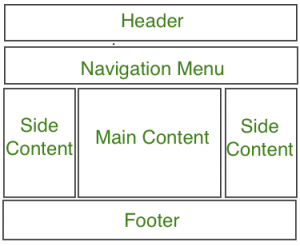

Create the HTMl code from this website mockup, each section should have a different color


In [49]:
# download and copy image locally
ui_image_url = "https://media.geeksforgeeks.org/wp-content/uploads/3-column-300x246.png"
ui_image_path = Path(ui_image_url).name
ui_image = get_image_from_anywhere(ui_image_url)
ui_image = ui_image.convert("RGB")
ui_image.save(ui_image_path)


# Prepare multimodal prompt
image = Image.load_from_file(ui_image_path)
prompt = "Create the HTMl code from this website mockup, each section should have a different color"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

In [50]:

from IPython.core.display import display, HTML

config = {"temperature": 0.0}
gemini_responses = multimodal_model.generate_content(
        multimodal_prompt,
        stream=True,
        generation_config=config
    )
streaming_chunks = []
for chunk in gemini_responses:
    chunk_text = chunk.text
    streaming_chunks.append(chunk_text)
    print(chunk_text, end="")

html_code = "".join(streaming_chunks)
display(HTML(html_code))

 ```html
<!DOCTYPE html>
<html>
<head>
  <title>Website Mockup</title>
  <style>
    header {
      background-color: #00FF00;
      padding: 20px;
      text-align: center;
    }

    nav {
      background-color: #FF00FF;
      padding: 20px;
      text-align: center;
    }

    main {
      background-color: #FFFFFF;
      padding: 20px;
    }

    aside {
      background-color: #FF0000;
      padding: 20px;
      text-align: center;
    }

    footer {
      background-color: #0000FF;
      padding: 20px;
      text-align: center;
    }
  </style>
</head>
<body>
  <header>
    <h1>Header</h1>
  </header>
  <nav>
    <a href="#">Navigation Menu</a>
  </nav>
  <main>
    <h1>Main Content</h1>
  </main>
  <aside>
    <h1>Side Content</h1>
  </aside>
  <footer>
    <h1>Footer</h1>
  </footer>
</body>
</html>
```

# Downstream tasks

# Image Classification

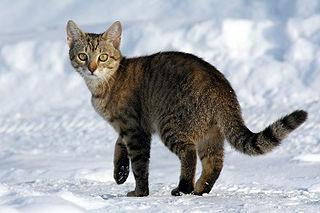

Classify the image, return the label in JSON format, with a label field


In [51]:
cat_image_uri = "gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg"
cat_image = get_image_from_anywhere(cat_image_uri)
cat_image = cat_image.convert("RGB")

# export image
cat_image_file = "cat.jpg"
cat_image.save(cat_image_file)

# Prepare contents
image = Image.load_from_file(cat_image_file)
prompt = "Classify the image, return the label in JSON format, with a label field"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

In [52]:
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
for result in gemini_responses:
    print(result.text, end="")

 ```json
{
  "label": "cat"
}
```

## Object Detection


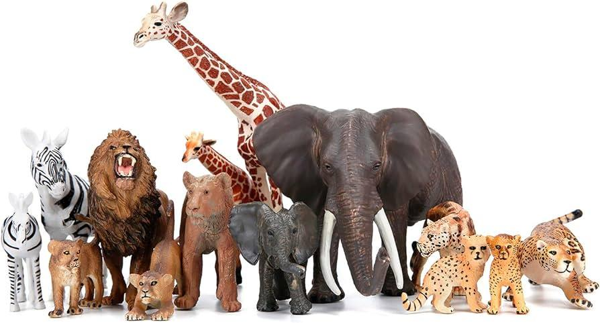

Detect the objects in the image, return the label and the bounding boxes in JSON format


In [54]:
# download image
zoo_image_url = "https://m.media-amazon.com/images/I/71LMIioO5tL._AC_UF894,1000_QL80_.jpg"
zoo_image = get_image_from_anywhere(zoo_image_url)
zoo_image = zoo_image.convert("RGB")

# export image
zoo_image_file = "zoo-animals.jpg"
zoo_image.save(zoo_image_file)

# Prepare contents
image = Image.load_from_file(zoo_image_file)
prompt = "Detect the objects in the image, return the label and the bounding boxes in JSON format"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

In [55]:
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
streaming_chunks = []
for result in gemini_responses:
    chunk_text = result.text
    streaming_chunks.append(chunk_text)
    print(chunk_text, end="")

 ```json
{
  "objects": [
    {
      "label": "elephant",
      "bounding_box": [
        426.0,
        244.0,
        634.0,
        441.0
      ]
    },
    {
      "label": "giraffe",
      "bounding_box": [
        23.0,
        66.0,
        200.0,
        443.0
      ]
    },
    {
      "label": "lion",
      "bounding_box": [
        250.0,
        243.0,
        350.0,
        339.0
      ]
    },
    {
      "label": "zebra",
      "bounding_box": [
        11.0,
        251.0,
        126.0,
        351.0
      ]
    },
    {
      "label": "lion",
      "bounding_box": [
        364.0,
        121.0,
        451.0,
        216.0
      ]
    },
    {
      "label": "elephant",
      "bounding_box": [
        453.0,
        118.0,
        560.0,
        212.0
      ]
    },
    {
      "label": "cheetah",
      "bounding_box": [
        644.0,
        250.0,
        730.0,
        304.0
      ]
    },
    {
      "label": "cheetah",
      "bounding_box": [
        735.0,
  

In [56]:
import json
import markdown
markdown_str = "".join(streaming_chunks)
bounding_boxes = markdown2json(markdown_str)
print(json.dumps(bounding_boxes, indent=2))

{
  "objects": [
    {
      "label": "elephant",
      "bounding_box": [
        426.0,
        244.0,
        634.0,
        441.0
      ]
    },
    {
      "label": "giraffe",
      "bounding_box": [
        23.0,
        66.0,
        200.0,
        443.0
      ]
    },
    {
      "label": "lion",
      "bounding_box": [
        250.0,
        243.0,
        350.0,
        339.0
      ]
    },
    {
      "label": "zebra",
      "bounding_box": [
        11.0,
        251.0,
        126.0,
        351.0
      ]
    },
    {
      "label": "lion",
      "bounding_box": [
        364.0,
        121.0,
        451.0,
        216.0
      ]
    },
    {
      "label": "elephant",
      "bounding_box": [
        453.0,
        118.0,
        560.0,
        212.0
      ]
    },
    {
      "label": "cheetah",
      "bounding_box": [
        644.0,
        250.0,
        730.0,
        304.0
      ]
    },
    {
      "label": "cheetah",
      "bounding_box": [
        735.0,
        250

### Video understanding

https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/intro_multimodal_use_cases.ipynb

**Question answering**

In [75]:
prompt_part = """
What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
Write a short poem with the tags on the image
"""
video_part = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/mediterraneansea.mp4",
    mime_type="video/mp4",
)
multimodal_prompt = [
    prompt_part,
    video_part
]

responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
print("-------Prompt--------")
print_multimodal_prompt(multimodal_prompt)



-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
Write a short poem with the tags on the image



In [76]:
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
for result in gemini_responses:
    print(result.text, end="")

 This is a photo of the Mediterranean Sea in Turkey.
You can visit this place by going to Turkey.
The top 5 places in the world that look like this are:
1. The Amalfi Coast, Italy
2. The Cinque Terre, Italy
3. Santorini, Greece
4. Positano, Italy
5. Dubrovnik, Croatia

Here is a short poem about the Mediterranean Sea:

The Mediterranean Sea
Is a beautiful place to be
With its crystal-clear waters
And its sandy beaches

The sun shines brightly
And the air is warm
It's the perfect place to relax
And forget about your troubles

So if you're looking for a place to get away
From it all
The Mediterranean Sea is the perfect place for you

**Tags extraction**

In [72]:
prompt = """
Answer the following questions using the video only:
- What is in the video?
- Provide 10 best tags for this video

Wrap the responses in a JSON object
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/photography.mp4",
    mime_type="video/mp4",
)
multimodal_prompt = [prompt, video]

gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(multimodal_prompt)

print("\n-------Response--------")
for response in gemini_responses:
    print(response.text, end="")

-------Prompt--------

Answer the following questions using the video only:
- What is in the video?
- Provide 10 best tags for this video

Wrap the responses in a JSON object




-------Response--------
 ```json
{
  "description": "This video is about a man taking pictures of a statue in a room.",
  "tags": ["man", "statue", "room", "photography", "art", "culture", "travel", "Mexico", "Latin America", "indigenous", "native", "American", "history", "archaeology", "museum", "gallery", "exhibition", "display", "collection", "artifact", "object", "work of art", "sculpture", "painting", "drawing", "print", "photograph", "video", "installation", "performance", "mixed media", "contemporary art", "modern art", "abstract art", "figurative art", "landscape art", "portrait art", "still life", "genre art", "history painting", "religious art", "mythological art", "allegorical art", "landscape painting", "portrait painting", "genre painting", "still life painting", "history painting", "religious painting", "mythological painting", "allegorical painting", "watercolor painting", "pastel painting", "drawing", "printmaking", "etching", "engraving", "lithography", "woodcut", "se

**Image comparison**

-------Prompt--------

Consider the following two images:
Image 1:



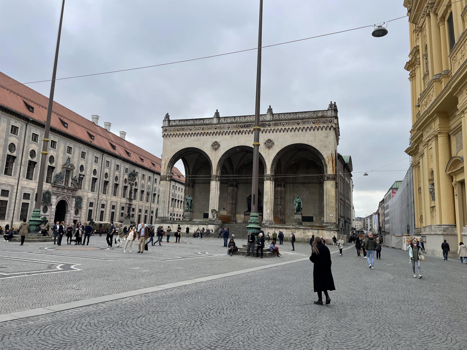


Image 2:



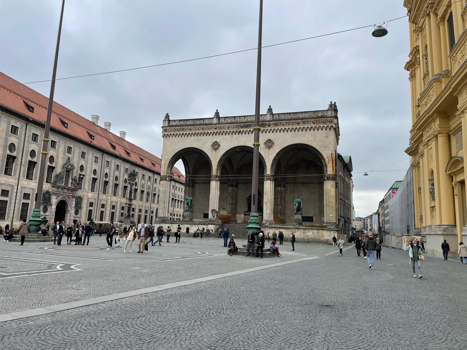


1. What is shown in Image 1?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?


-------Response--------
 1. Image 1 shows a square with a large building in the background. There are people walking around the square.
2. Both images show the same square with the same buildings in the background.
3. The difference between the two images is that there are more people in Image 1.

In [77]:
image_landmark1_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark1.jpg"
image_landmark2_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark2.jpg"
image_landmark1 = get_image_from_anywhere(image_landmark1_url)
image_landmark2 = get_image_from_anywhere(image_landmark2_url)

image_landmark1.save("image1.jpg")
image_landmark2.save("image2.jpg")


image_part_1 = Image.load_from_file("image1.jpg")
image_part_2 =  Image.load_from_file("image2.jpg")

prompt1 = """
Consider the following two images:
Image 1:
"""
prompt2 = """
Image 2:
"""
prompt3 = """
1. What is shown in Image 1?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?
"""

contents = [prompt1, image_part_1, prompt2, image_part_2, prompt3]

generation_config = GenerationConfig(
    temperature=0.0,
    top_p=0.8,
    top_k=40,
    candidate_count=1, # # Generate only one output
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Sequence of images understanding

-------Prompt--------
Consider the following chairs:
chair 1:


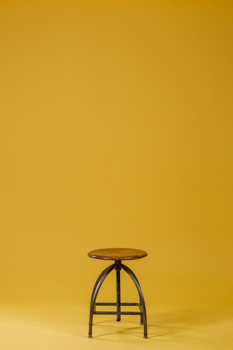

chair 2:


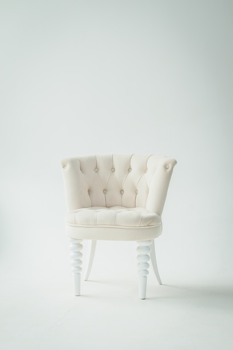

chair 3:


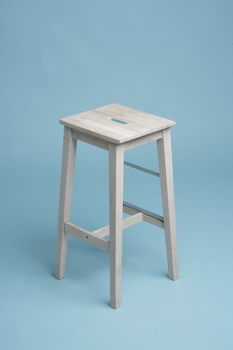

chair 4:


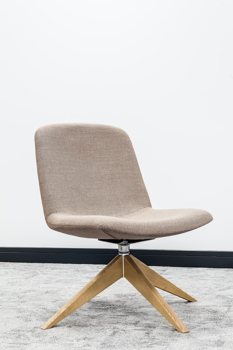

Which one is white color?

-------Response--------
 The second chair is white color.

In [80]:
import http.client
import io
import typing
import urllib.request

# Download and display sample images
furniture_image_urls = [
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg",
]

def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        if response.headers["Content-Type"] not in ("image/png", "image/jpeg"):
            raise Exception("Image can only be in PNG or JPEG format")
        image_bytes = response.read()
    return image_bytes


def image_part_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


# Load furniture images as Image Objects
furniture_images = [image_part_from_url(url) for url in furniture_image_urls]

# To recommend an item from a selection, you will need to label the item number within the prompt.
# That way you are providing the model with a way to reference each image as you pose a question.
# Labelling images within your prompt also help to reduce hallucinations and overall produce better results.
contents = [
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "Which one is white color?",
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Putting everything together into a multimodal RAG system


https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb